_Version log: Optimisation using Principle Component Analysis._

In [65]:
import sys, warnings, os
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, linalg as spla
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [66]:
import os
import CS_functions as cs
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as spla
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

In [67]:
training_dataset = 4

training_directory = "data\\training_set{0:}\\".format(training_dataset)
training_file_paths = [os.path.join(training_directory, file_name) for file_name in os.listdir(training_directory)]

training_data = np.array([np.genfromtxt(file_path, delimiter=",", filling_values= np.nan) for file_path in training_file_paths])

training_data = np.rollaxis(training_data, -1, 0) # move the last axis to the front
training_interferograms, training_uncertainty = training_data # now we can seperate the interferograms from the uncertainties. :)

training_interferograms.shape

(2500, 200)

In [68]:
interferogram_to_test = 11

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = cs.open_dataset(test_file_name, ".csv")

In [69]:
number_of_pca_components = None # use `None` for all of them.

pca = PCA(n_components= number_of_pca_components)
pca.fit(training_interferograms) # is it possible to weight the datapoints using the uncertainty?

relitive_importance = pca.explained_variance_ratio_ #The most important component is first.
print(len(relitive_importance))

200


In [70]:
number_of_pca_components = None # use `None` for all of them.

pca = PCA(n_components= number_of_pca_components)
pca.fit(training_interferograms) # is it possible to weight the datapoints using the uncertainty?

relitive_importance = pca.explained_variance_ratio_ #The most important component is first.
basis_transform = pca.components_ # components in the original basis.

sparse_interferograms = pca.transform(training_interferograms) #transform the interferograms into the sparse basis
test_in_new_basis = pca.transform(test_interferogram[None, :])

# Reconstruct original data
recovered_interferogram = pca.inverse_transform(test_in_new_basis)[0]
recovered_interferogram2 = np.matmul(test_in_new_basis, basis_transform)[0] + pca.mean_ # like lasso, pca also normalises the data so the mean is more difficult to recover.

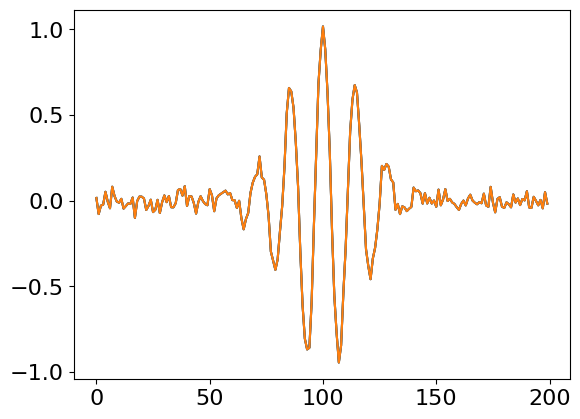

In [71]:
plt.plot(test_interferogram, color= "k")

plt.plot(recovered_interferogram)
plt.plot(recovered_interferogram2) #Should be the same

plt.show()

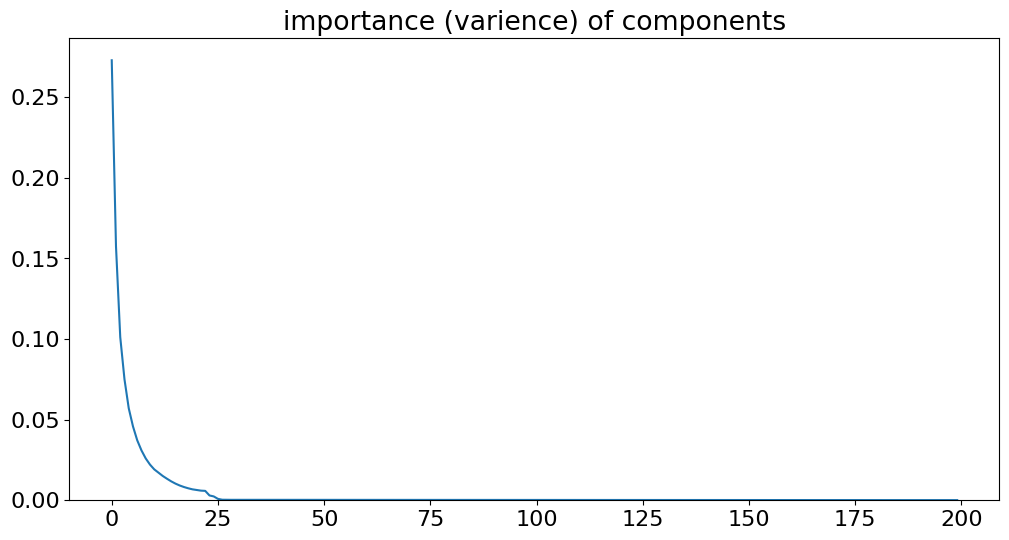

In [72]:
fig, axs = plt.subplots(1, 1, figsize= (12, 6))

axs.plot(relitive_importance)
axs.set(ylim= (0, None), title= "importance (varience) of components")

plt.show()

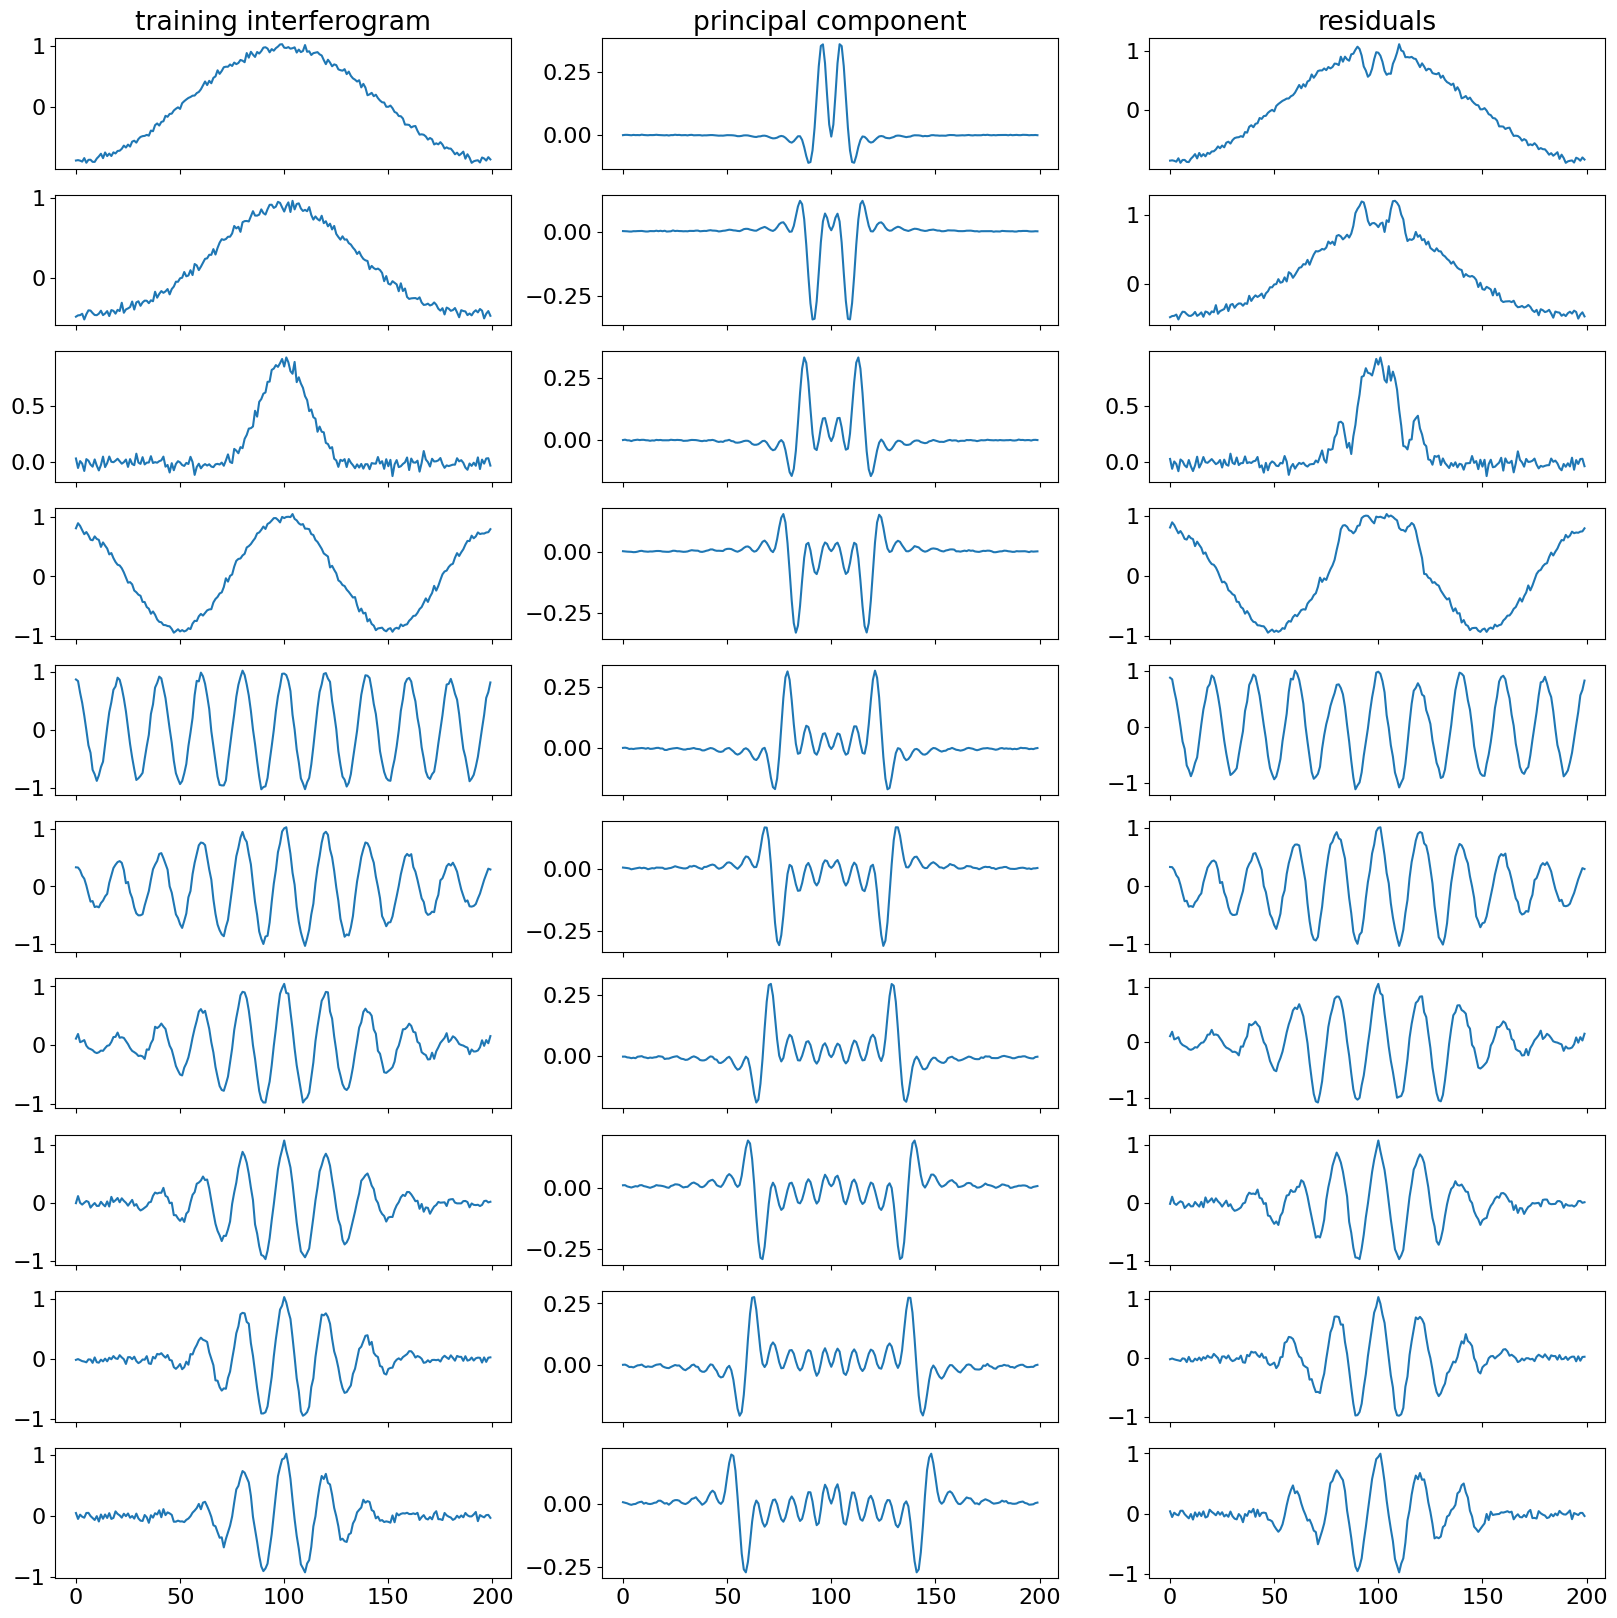

In [73]:
inds = np.arange(10) #np.random.randint(len(training_interferograms), size=10)

fig, axs = plt.subplots(len(inds), 3, figsize= (20, 2*len(inds)), sharex= True)

axs[0,0].set(title= "training interferogram")
axs[0,1].set(title= "principal component")
axs[0,2].set(title= "residuals")

for ax_row, k in zip(axs, inds):
    ax_row[0].plot(training_interferograms[k])

    ax_row[1].plot(basis_transform[k])

    ax_row[2].plot(training_interferograms[k] -basis_transform[k])

plt.show()

In [74]:
# Compute QR factorization with column pivoting
Q, R, permutation_matrix = spla.qr(basis_transform, pivoting= True)

# P is the permutation matrix
print("Permutation Matrix (P):")
print(permutation_matrix)


Permutation Matrix (P):
[  0  31   8  17  25  59  69  95 193  26  96 163  33  18  19  30  37  39
  44  28  35  48  52  57  74 125 166  41  43  88 132   7 102 118 124  21
  71 131 147 117 120 133 123 139 140 192  36  47  82 110 197  78  87  97
 101  13 146 155 186  12 130  24 106  27 165  99 105  75 161  51  34  16
 162 178  22  63 137  45   6  83  29   4 129  46  15  67 144  38 153  23
 159 160  64 173 187  53  65  32  62  49 111 116 119  42  60  84 138 145
  56 149 156  11 167 168 171  50   5 103 127  79 109  72 100 172  93 176
 177 188  77 115 104  66  76 143 108 148  90   9 114 175  73 179 185 194
  20 199  89 158  91 121  92   1 112 113   3  70  81 141 182 128  68 164
 150 151 152  80 169 154 134  10 157 183 184 142 191 195 126  98 189 190
  85  86 107 170  14 198  94  55 122 174 180 135  61   2  54  58  40 136
 181 196]


In [75]:
number_of_detectors = 8
regularization_coeffient = 1e-4

detectors = permutation_matrix[:number_of_detectors]

print(*np.sort(detectors), sep= ",")

0,8,17,25,31,59,69,95


In [76]:
samples = test_interferogram[detectors]
measurement_matrix = basis_transform[:,detectors]
mean = np.mean(samples)

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(basis_transform.T, lasso.coef_) +mean

In [77]:
samples_with_gaps = np.full_like(test_interferogram, np.nan)
samples_with_gaps[detectors] = test_interferogram[detectors]
result2 = cs.compressed_sensing(samples_with_gaps, regularization_coeffient)

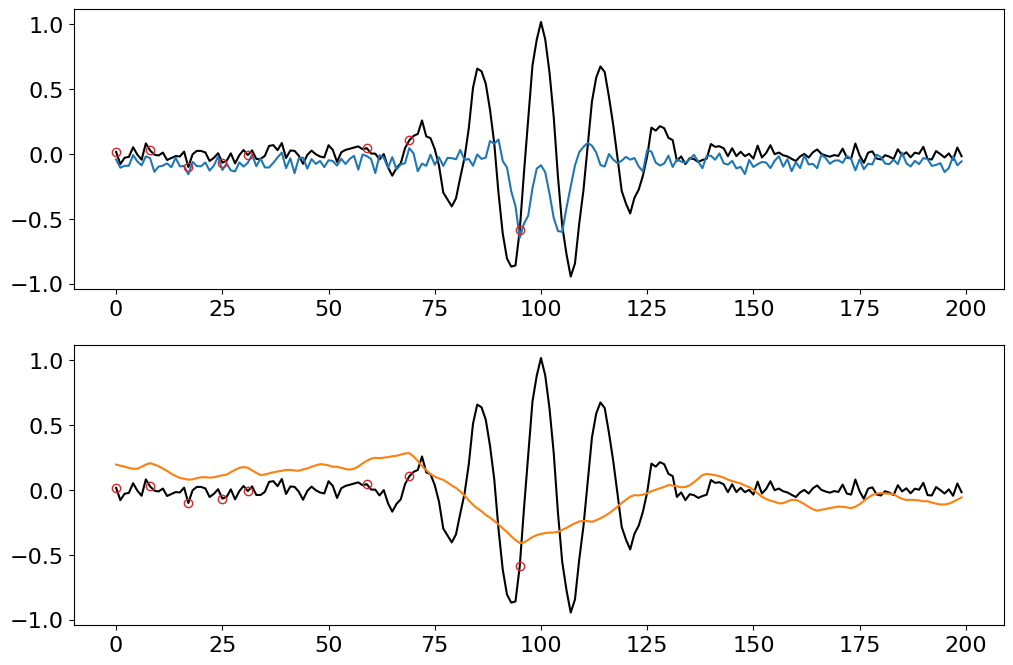

In [78]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")

plt.show()